In [1]:
!MINIMAL=1 pip install kats

In [2]:
!pip install "numpy==1.20"

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.style.use('seaborn-whitegrid')
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = "17"

* Load the COVID cases dataset.

In [4]:
import pandas as pd

owid_covid = pd.read_csv("https://covid.ourworldindata.org/data/owid-covid-data.csv")
owid_covid["date"] = pd.to_datetime(owid_covid["date"])
df = owid_covid[owid_covid.location == "France"].set_index("date", drop=True).resample('D').interpolate(method='linear').reset_index()

* Configure the ensemble model, fit it, and then do a forecast.
* Create ensemble parameters that define how the ensemble aggregate
is to be calculated and how the decomposition should work.

In [5]:
from kats.models.ensemble.ensemble import EnsembleParams, BaseModelParams
from kats.models.ensemble.kats_ensemble import KatsEnsemble
from kats.models import (
    linear_model,
    quadratic_model
)


model_params = EnsembleParams(
            [
                BaseModelParams("linear", linear_model.LinearModelParams()),
                BaseModelParams("quadratic", quadratic_model.QuadraticModelParams()),
            ]
        )

# create `KatsEnsembleParam` with detailed configurations 
KatsEnsembleParam = {
    "models": model_params,
    "aggregation": "weightedavg",
    "seasonality_length": 30,
    "decomposition_method": "additive",
}

* To use a time-series with Kats, convert the data from a DataFrame or
series to a Kats time-series object. 

In [6]:
from kats.consts import TimeSeriesData
TARGET_COL = "new_cases"

df_ts = TimeSeriesData(
    value=df[TARGET_COL], time=df["date"]
)

* Create KatsEnsemble and fit it.

In [7]:
m = KatsEnsemble(
    data=df_ts, 
    params=KatsEnsembleParam
).fit()

In [8]:
m.predict(steps=90).aggregate()

,time,fcst,fcst_lower,fcst_upper
0,2021-11-27,11759.641534,-11223.106721,34742.389789
1,2021-11-28,10327.348328,-12656.820715,33311.517370
2,2021-11-29,11373.844429,-11611.759461,34359.448320
3,2021-11-30,9816.164518,-13170.888367,32803.217404
4,2021-12-01,4455.793133,-18532.722979,27444.309244
...,...,...,...,...
85,2022-02-20,-12211.775811,-35374.266260,10950.714637
86,2022-02-21,9311.956063,-13853.471937,32477.384064
87,2022-02-22,8700.382663,-14468.004801,31868.770128
88,2022-02-23,7765.252009,-15406.116931,30936.620949


* Separate predictions for each model using the predict() method.
* To get the ensemble output, call aggregate() after predict().
* Plot the aggregated DataFrame using a Kats convenience function.

Text(14.375, 0.5, 'new_cases')

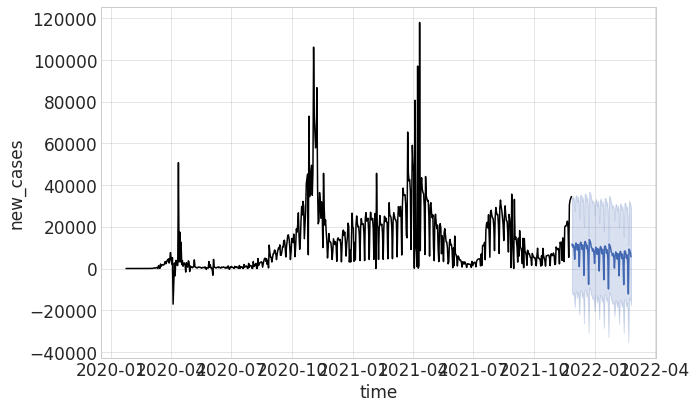

In [9]:
m.predict(steps=90)
m.aggregate()
m.plot()
plt.ylabel(TARGET_COL)